First, ```1_Cleaning_and_types``` and ```2_Targets_preparation``` code goes:

In [1]:
### 1_Cleaning_and_types ###

import pandas as pd
pd.options.display.max_columns = None

# Load dataframe with first column as the index
df = pd.read_csv('../rec_sys_alumnos.csv', index_col=0, dtype=str)

# Drop 'fec_ult_cli_1t' column as it as only 36 non-null records out of 634682 records
df.drop('fec_ult_cli_1t', axis=1, inplace=True)

# Trim spaces at the beginning and at the end of each record
df = df.apply(lambda x: x.str.strip())

# Set 'NA' strings as nan value
df = df.replace('NA', float('nan'))

columns = df.columns.tolist()

# Manual classification of columns by their type (products are already binary)
asint = [0, 4, 8, 17]
products = list(range(22, 47))
asfloat = [19, 21]
asdate = [1, 5]
ascategory = [2, 6, 10, 11, 14, 20]
asbinary = [3, 7, 9, 12, 13, 15, 16, 18]

# Transform some columns to binary
from numpy import mod
for i in asbinary:
    options = pd.Series(df[columns[i]].unique()).sort_values().values
    binary = [0, 1]
    for j in [-2, -3]:
        df[columns[i]] = df[columns[i]].replace(options[mod(j, len(options))], binary[mod(j, len(binary)+1)])

# Convert numeric columns to float (including binary)
for i in asfloat + asint + products + asbinary:
    df[columns[i]] = df[columns[i]].astype('float64')

# Convert date columns to datetime
for i in asdate:
    df[columns[i]] = pd.to_datetime(df[columns[i]])

# Special case for 'xti_rel_1mes' that has numbers within the categories and differenciates between int and float
def try_float(x):
    try:
        return int(float(x))
    except ValueError:
        return x
df['xti_rel_1mes'] = df['xti_rel_1mes'].apply(lambda x: try_float(x))

# Convert some columns to categorical
for i in ascategory:
    df[columns[i]] = df[columns[i]].astype('category')


# ====================================================================================================


### 2_Targets_preparation ###

meses = pd.Series(df['mes'].unique()).sort_values().values

# List of dataframes. Each dataframe contains the records corresponding to one month
df_xmes = [df[df['mes'] == mes] for mes in meses]

# Create a new DataFrame with the same features but the products and the date
df_status = df[[columns[i] for i in range(0, 23)]].copy()
# List of dataframes. Each dataframe contains the records corresponding to in-between months
df_status_xmes = [df_status[df_status['mes'] == mes].drop('mes', axis=1) for mes in meses[1:]]

# For each month calculate the product status with respect to the previous month, and store it in "df_status_xmes".
# After each calculation, append the DataFrame to new DataFrame "df_status"
del(df_status)
df_status = pd.DataFrame(columns=columns)

for i in range(len(df_xmes) - 1):
    product_status = df_xmes[i+1].merge(df_xmes[i][[columns[p0] for p0 in [0]+products]], on='cod_persona', how='left')
    for p in products:
        df_status_xmes[i][columns[p]] = product_status[columns[p]+'_x'].fillna(0).values - \
                                        product_status[columns[p]+'_y'].fillna(0).values
    df_status_xmes[i]['mes'] = str(meses[i])[:7] + ' \u2192 ' + str(meses[i+1])[:7]
    df_status = df_status.append(df_status_xmes[i])

df_status

,cod_persona,mes,pais,sexo,edad,fecha1,xti_empleado,xti_nuevo_cliente,num_antiguedad,xti_rel,xti_rel_1mes,tip_rel_1mes,indresi,indext,des_canal,xti_extra,tip_dom,cod_provincia,xti_actividad_cliente,imp_renta,id_segmento,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25
31537,1008590.0,2015-01 → 2015-02,ES,1.0,45.0,2005-08-02,N,0.0,120.0,0.0,1.0,I,1.0,0.0,KAT,0.0,1.0,28.0,1.0,62736.12,02 - PARTICULARES,6.926724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31538,1008582.0,2015-01 → 2015-02,ES,0.0,65.0,2005-08-02,N,0.0,120.0,0.0,1.0,I,1.0,0.0,KBZ,0.0,1.0,28.0,0.0,NaN,02 - PARTICULARES,8.280778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31539,1008547.0,2015-01 → 2015-02,ES,1.0,52.0,2005-08-02,N,0.0,120.0,0.0,1.0,A,1.0,0.0,KFC,0.0,1.0,39.0,1.0,64413.75,02 - PARTICULARES,7.429623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31540,1008663.0,2015-01 → 2015-02,ES,1.0,48.0,2005-08-24,N,0.0,119.0,0.0,1.0,A,1.0,0.0,KFA,0.0,1.0,28.0,1.0,1242325.23,01 - TOP,7.146723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31542,1008466.0,2015-01 → 2015-02,ES,1.0,49.0,2005-08-03,N,0.0,119.0,0.0,1.0,I,1.0,0.0,KFC,0.0,1.0,43.0,0.0,66302.13,02 - PARTICULARES,7.218520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641702,256354.0,2016-03 → 2016-04,ES,1.0,25.0,2014-08-18,N,0.0,25.0,0.0,1.0,A,1.0,0.0,RED,0.0,1.0,30.0,1.0,81987.18,02 - PARTICULARES,5.218520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
641703,256273.0,2016-03 → 2016-04,ES,0.0,65.0,2014-08-18,N,0.0,20.0,0.0,1.0,I,1.0,0.0,KAT,0.0,1.0,41.0,0.0,131135.70,02 - PARTICULARES,8.280778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
641704,256253.0,2016-03 → 2016-04,ES,1.0,42.0,2014-08-18,N,0.0,20.0,0.0,1.0,I,1.0,0.0,KFC,0.0,1.0,8.0,0.0,74745.30,02 - PARTICULARES,6.699261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
641705,256296.0,2016-03 → 2016-04,ES,0.0,42.0,2014-08-18,N,0.0,20.0,0.0,1.0,I,1.0,0.0,KFC,0.0,1.0,28.0,0.0,215942.10,02 - PARTICULARES,6.699261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The resulting dataframe has several null records. Before any feature engineering, a study must be performed on this nulls, to decide if they are dropped or imputed and how.

In [2]:
df_status.isna().sum()

cod_persona                   0
mes                           0
pais                         39
sexo                         48
edad                         39
fecha1                       39
xti_empleado                 39
xti_nuevo_cliente            39
num_antiguedad               39
xti_rel                      39
xti_rel_1mes               5625
tip_rel_1mes               5625
indresi                      39
indext                       39
des_canal                  7160
xti_extra                    39
tip_dom                       0
cod_provincia              2758
xti_actividad_cliente        39
imp_renta                119131
id_segmento                7385
mean_engagement            5625
ind_prod1                     0
ind_prod2                     0
ind_prod3                     0
ind_prod4                     0
ind_prod5                     0
ind_prod6                     0
ind_prod7                     0
ind_prod8                     0
ind_prod9                     0
ind_prod

* ```tip_dom``` and ```ind_prodX``` have no nulls, so they are already set.


* ```fec_ult_cli_1t``` was already dropped at the beginning.

* ```pais```, ```edad```, ```fecha1```, ```xti_empleado```, ```xti_nuevo_cliente```, ```num_antiguedad```, ```xti_rel```, ```indresi```, ```indext```, ```xti_extra``` and ```xti_actividad_cliente``` have the same number of nulls: 39. A quick check shows that they correspond to the same records. Hence, it is convenient to drop those records, since a lot of information is held in those columns.

In [3]:
df_status[df_status['pais'].isna() &
          df_status['edad'].isna() &
          df_status['fecha1'].isna() &
          df_status['xti_empleado'].isna() &
          df_status['xti_nuevo_cliente'].isna() &
          df_status['num_antiguedad'].isna() &
          df_status['xti_rel'].isna() &
          df_status['indresi'].isna() &
          df_status['indext'].isna() &
          df_status['xti_extra'].isna() &
          df_status['xti_actividad_cliente'].isna()
         ].shape[0]

39

In [4]:
# pais, edad, fecha1, xti_empleado, xti_nuevo_cliente, num_antiguedad, xti_rel, indresi, indext, xti_extra, xti_actividad_cliente
# Drop 39 records with nulls
df_status.drop(df_status[df_status['pais'].isna()].index, inplace=True)

* ```imp_renta``` has around 1/6 of the records in blank. Before deciding which imputation will be done, it is necessary to see the distribution of this variable. A boxplot shows that the outliers are too far away from the box; furthermore, the standard deviation is even higher than the mean.

Number of outliers: 28662
Mean: 136637.1335427334
Std: 333715.2416000251
Median: 101253.75


<AxesSubplot:>

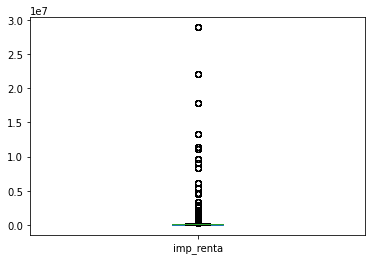

In [5]:
Q1 = df_status['imp_renta'].quantile(0.25)
Q3 = df_status['imp_renta'].quantile(0.75)
IQR = Q3 - Q1
n_outliers = ((df_status['imp_renta'] < (Q1 - 1.5 * IQR)) | (df_status['imp_renta'] > (Q3 + 1.5 * IQR))).sum()
print('Number of outliers:', n_outliers)

print('Mean:', df_status['imp_renta'].mean())
print('Std:', df_status['imp_renta'].std())
print('Median:', df_status['imp_renta'].median())

df_status['imp_renta'].plot.box()

In [6]:
# imp_renta
# DECIDE WHICH IMPUTATION IS PERFORMED OR DROP THESE RECORDS. FOR EXAMPLE:
df_status['imp_renta'] = df_status['imp_renta'].replace(float('nan'), df_status['imp_renta'].median())

* ```mean_engagement``` does not have too many nulls, but it is a numeric column and a study similar to that of ```imp_renta``` should be done.<br>
It seems that there are many outliers but compared with the 6 hundred thousand records they are just a few. Furthermore, the median is close to the mean, even though the standard deviation is a 21% of the mean.

Number of outliers: 276
Mean: 6.42501558959862
Std: 1.3476204172320496
Median: 6.463518112854217


<AxesSubplot:>

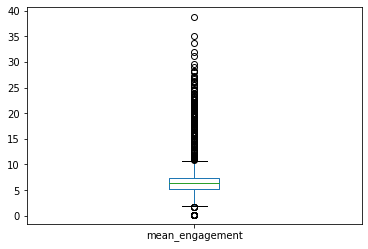

In [7]:
Q1 = df_status['mean_engagement'].quantile(0.25)
Q3 = df_status['mean_engagement'].quantile(0.75)
IQR = Q3 - Q1
n_outliers = ((df_status['mean_engagement'] < (Q1 - 1.5 * IQR)) | (df_status['mean_engagement'] > (Q3 + 1.5 * IQR))).sum()
print('Number of outliers:', n_outliers)

print('Mean:', df_status['mean_engagement'].mean())
print('Std:', df_status['mean_engagement'].std())
print('Median:', df_status['mean_engagement'].median())

df_status['mean_engagement'].plot.box()

In [8]:
# mean_engagement
# DECIDE WHICH IMPUTATION IS PERFORMED OR DROP THESE RECORDS. FOR EXAMPLE:
df_status['mean_engagement'] = df_status['mean_engagement'].replace(float('nan'), df_status['mean_engagement'].mean())

* ```cod_provincia``` is a numeric column but each number is a code that matches a category (provinces). However, missing data could correspond to categories different than the categories already recorded, so they can be imputed with 'Other' category, or, in terms of numbers, with '0'.

In [9]:
# cod_provincia
# Replace 'nan' values with 0
df_status['cod_provincia'] = df_status['cod_provincia'].replace(float('nan'), 0)

* ```des_canal``` is a categoric column that indicates the customer channel. Null data can be categorized as "Other".
<br> It is important to note that 'Other' is not included in the set of categories yet, so in order to replace ```nan```s with 'Other', this last must be added to the set of categories.

In [10]:
# des_canal
# Add 'Other' category and fill the 'nan' values with 'Other'
df_status['des_canal'] = df_status['des_canal'].cat.add_categories('Other').fillna('Other')

* Finally, ```sexo```, ```xti_rel_1mes```, ```tip_rel_1mes``` and ```id_segmento``` are categorical or binary columns and can be imputed in a simple way.<br>

In [11]:
# sexo, xti_rel_1mes, tip_rel_1mes, id_segmento
# DECIDE WHICH IMPUTATION IS PERFORMED OR DROP THESE RECORDS. FOR EXAMPLE:
from numpy import array
from numpy.random import choice
for col in ['sexo', 'xti_rel_1mes', 'tip_rel_1mes', 'id_segmento']:
    options = list(df_status[col].value_counts().to_dict().keys())
    value_counts = array(list(df_status[col].value_counts().to_dict().values()))
    probabs = value_counts / sum(value_counts)
    choices = {ind: choice(options, p=probabs) for ind in df_status[df_status[col].isna()].index}
    df_status[col] = df_status[col].fillna(choices)

In [12]:
# Convert all columns with integer thata to int
for i in asint + products + asbinary:
    df_status[columns[i]] = df_status[columns[i]].astype('int64')

Check that there are not nulls anymore and that the types are correct.

In [13]:
df_status.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 603794 entries, 31537 to 641706
Data columns (total 47 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   cod_persona            603794 non-null  int64         
 1   mes                    603794 non-null  object        
 2   pais                   603794 non-null  category      
 3   sexo                   603794 non-null  int64         
 4   edad                   603794 non-null  int64         
 5   fecha1                 603794 non-null  datetime64[ns]
 6   xti_empleado           603794 non-null  category      
 7   xti_nuevo_cliente      603794 non-null  int64         
 8   num_antiguedad         603794 non-null  int64         
 9   xti_rel                603794 non-null  int64         
 10  xti_rel_1mes           603794 non-null  category      
 11  tip_rel_1mes           603794 non-null  category      
 12  indresi                603794 non-null  

In [14]:
df_status.isna().sum()

cod_persona              0
mes                      0
pais                     0
sexo                     0
edad                     0
fecha1                   0
xti_empleado             0
xti_nuevo_cliente        0
num_antiguedad           0
xti_rel                  0
xti_rel_1mes             0
tip_rel_1mes             0
indresi                  0
indext                   0
des_canal                0
xti_extra                0
tip_dom                  0
cod_provincia            0
xti_actividad_cliente    0
imp_renta                0
id_segmento              0
mean_engagement          0
ind_prod1                0
ind_prod2                0
ind_prod3                0
ind_prod4                0
ind_prod5                0
ind_prod6                0
ind_prod7                0
ind_prod8                0
ind_prod9                0
ind_prod10               0
ind_prod11               0
ind_prod12               0
ind_prod13               0
ind_prod14               0
ind_prod15               0
i